In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [47]:
import sys

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/sentix_nlp"
DATA_DIR = ABSOLUTE_PATH + "/data"
EXPORT_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"

sys.path.insert(0, ABSOLUTE_PATH)

# Data Preprocessing for CryptoBERT

In [48]:
import os
import re
import html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from tqdm import tqdm

 ## Loading the dataset

In [49]:
df = pd.read_csv(os.path.join(DATA_DIR, "coindesk_news.csv"))
df.shape

(15000, 18)

In [50]:
df.columns.tolist()

['id',
 'guid',
 'title',
 'subtitle',
 'content',
 'published_date',
 'published_timestamp',
 'url',
 'image_url',
 'authors',
 'source_id',
 'keywords',
 'language',
 'upvotes',
 'downvotes',
 'score',
 'sentiment',
 'status']

In [51]:
df.head()

,id,guid,title,subtitle,content,published_date,published_timestamp,url,image_url,authors,source_id,keywords,language,upvotes,downvotes,score,sentiment,status
0,43634416,https://thedefiant.io/news/tradfi-and-fintech/...,Circle to Launch Global Payments and Cross-Bor...,NaN,"Circle, the issuer of USDC, the second-largest...",2025-04-21 20:35:08,1745264108,https://thedefiant.io/news/tradfi-and-fintech/...,https://resources.cryptocompare.com/news/101/4...,DeepNewz,101,NaN,EN,0,0,0,POSITIVE,ACTIVE
1,43634328,https://crypto.news/?p=14371397,Coinbase secures more SEC documents on Ethereu...,NaN,Coinbase has obtained internal documents from ...,2025-04-21 20:33:50,1745264030,https://crypto.news/coinbase-secures-more-sec-...,https://resources.cryptocompare.com/news/73/43...,Micah Zimmerman,73,News|Coinbase|Lawsuit|SEC,EN,0,0,0,NEUTRAL,ACTIVE
2,43634351,https://en.coinotag.com/onyxcoin-faces-uncerta...,Onyxcoin Faces Uncertainty with Signs of Poten...,NaN,Onyxcoin (XCN) has experienced a significant p...,2025-04-21 20:33:41,1745264021,https://en.coinotag.com/onyxcoin-faces-uncerta...,https://resources.cryptocompare.com/news/77/43...,Marisol Navaro,77,Analysis|News,EN,0,0,0,NEUTRAL,ACTIVE
3,43634547,https://thecoinrise.com/circle-floats-new-paym...,Circle Floats New Payments Network For Cross-B...,NaN,"On Tuesday, Circle, the company behind the wel...",2025-04-21 20:31:37,1745263897,https://thecoinrise.com/circle-floats-new-paym...,https://resources.cryptocompare.com/news/60/43...,Godfrey Benjamin,60,Blockchain News|Circle|Stablecoin,EN,0,0,0,POSITIVE,ACTIVE
4,43634269,https://en.coin-turk.com/?p=189832,Maximize Your Crypto Gains with Kernel DAO’s I...,NaN,Kernel DAO offers enhanced security and yields...,2025-04-21 20:31:36,1745263896,https://en.coin-turk.com/maximize-your-crypto-...,https://resources.cryptocompare.com/news/79/43...,Fatih Uçar,79,Altcoin News,EN,0,0,0,POSITIVE,ACTIVE


In [52]:
df.isnull().sum()

,0
id,0
guid,0
title,0
subtitle,14637
content,52
published_date,0
published_timestamp,0
url,0
image_url,0
authors,360


## Data cleaning

In [53]:
def clean_text(text):
    if pd.isna(text):
        return ""

    # Remove HTML tags
    text = html.unescape(text)
    text = re.sub(r'<.*?>', ' ', text)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Normalise whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Convert to lowercase
    text = text.lower()

    # Handle tickers e.g., $BTC -> BTC, (ETH) -> ETH
    text = re.sub(r'[$\(\)]', '', text)

    return text

# Apply cleaning to the content column
df['cleaned_content'] = df['content'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)

# Combine title and content for a complete text field
df['full_text'] = df['cleaned_title'] + ". " + df['cleaned_content']

### Drop duplicates

In [54]:
original_length = len(df)
df.drop_duplicates(subset=['full_text'], inplace=True)

print(f"Removed {original_length - len(df)} duplicate articles.")

Removed 54 duplicate articles.


## Data normalisation

In [55]:
df.head()

,id,guid,title,subtitle,content,published_date,published_timestamp,url,image_url,authors,...,keywords,language,upvotes,downvotes,score,sentiment,status,cleaned_content,cleaned_title,full_text
0,43634416,https://thedefiant.io/news/tradfi-and-fintech/...,Circle to Launch Global Payments and Cross-Bor...,NaN,"Circle, the issuer of USDC, the second-largest...",2025-04-21 20:35:08,1745264108,https://thedefiant.io/news/tradfi-and-fintech/...,https://resources.cryptocompare.com/news/101/4...,DeepNewz,...,NaN,EN,0,0,0,POSITIVE,ACTIVE,"circle, the issuer of usdc, the second-largest...",circle to launch global payments and cross-bor...,circle to launch global payments and cross-bor...
1,43634328,https://crypto.news/?p=14371397,Coinbase secures more SEC documents on Ethereu...,NaN,Coinbase has obtained internal documents from ...,2025-04-21 20:33:50,1745264030,https://crypto.news/coinbase-secures-more-sec-...,https://resources.cryptocompare.com/news/73/43...,Micah Zimmerman,...,News|Coinbase|Lawsuit|SEC,EN,0,0,0,NEUTRAL,ACTIVE,coinbase has obtained internal documents from ...,coinbase secures more sec documents on ethereu...,coinbase secures more sec documents on ethereu...
2,43634351,https://en.coinotag.com/onyxcoin-faces-uncerta...,Onyxcoin Faces Uncertainty with Signs of Poten...,NaN,Onyxcoin (XCN) has experienced a significant p...,2025-04-21 20:33:41,1745264021,https://en.coinotag.com/onyxcoin-faces-uncerta...,https://resources.cryptocompare.com/news/77/43...,Marisol Navaro,...,Analysis|News,EN,0,0,0,NEUTRAL,ACTIVE,onyxcoin xcn has experienced a significant pul...,onyxcoin faces uncertainty with signs of poten...,onyxcoin faces uncertainty with signs of poten...
3,43634547,https://thecoinrise.com/circle-floats-new-paym...,Circle Floats New Payments Network For Cross-B...,NaN,"On Tuesday, Circle, the company behind the wel...",2025-04-21 20:31:37,1745263897,https://thecoinrise.com/circle-floats-new-paym...,https://resources.cryptocompare.com/news/60/43...,Godfrey Benjamin,...,Blockchain News|Circle|Stablecoin,EN,0,0,0,POSITIVE,ACTIVE,"on tuesday, circle, the company behind the wel...",circle floats new payments network for cross-b...,circle floats new payments network for cross-b...
4,43634269,https://en.coin-turk.com/?p=189832,Maximize Your Crypto Gains with Kernel DAO’s I...,NaN,Kernel DAO offers enhanced security and yields...,2025-04-21 20:31:36,1745263896,https://en.coin-turk.com/maximize-your-crypto-...,https://resources.cryptocompare.com/news/79/43...,Fatih Uçar,...,Altcoin News,EN,0,0,0,POSITIVE,ACTIVE,kernel dao offers enhanced security and yields...,maximize your crypto gains with kernel dao’s i...,maximize your crypto gains with kernel dao’s i...


 ## Tokenization and Encoding

100%|██████████| 1000/1000 [00:04<00:00, 225.98it/s]


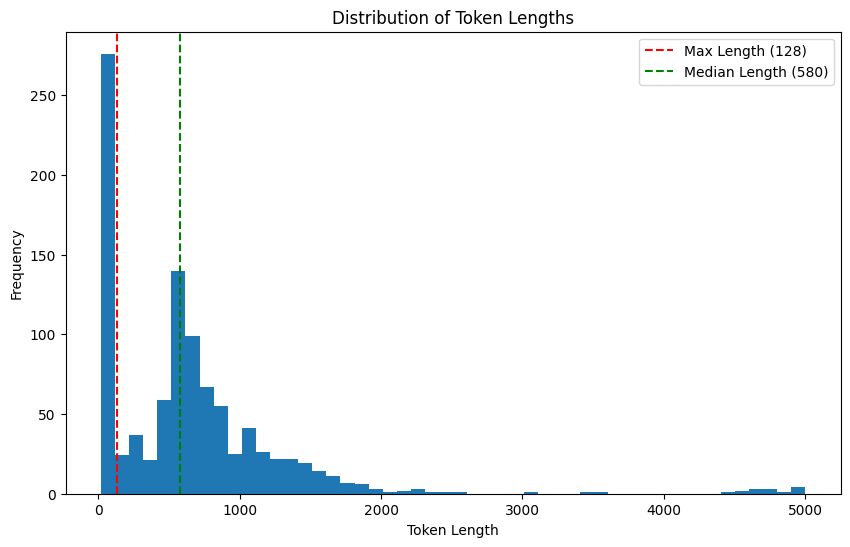

Median token length: 580.0
Mean token length: 660.507
Max token length: 5003
Percentage of samples longer than 128 tokens: 72.10%


In [56]:
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")

# Check the length of tokenized sequences
token_lengths = []
for text in tqdm(df['full_text'].sample(min(1000, len(df))).tolist()):
    tokens = tokenizer.encode(text)
    token_lengths.append(len(tokens))

# Plot histogram of token lengths
def plot_token_length_histogram(token_lengths):
  plt.figure(figsize=(10, 6))
  plt.hist(token_lengths, bins=50)
  plt.xlabel('Token Length')
  plt.ylabel('Frequency')
  plt.title('Distribution of Token Lengths')
  plt.axvline(x=128, color='r', linestyle='--', label='Max Length (128)')
  plt.axvline(x=np.median(token_lengths), color='g', linestyle='--', label=f'Median Length ({np.median(token_lengths):.0f})')
  plt.legend()
  plt.show()

plot_token_length_histogram(token_lengths)

print(f"Median token length: {np.median(token_lengths)}")
print(f"Mean token length: {np.mean(token_lengths)}")
print(f"Max token length: {np.max(token_lengths)}")
print(f"Percentage of samples longer than 128 tokens: {sum(length > 128 for length in token_lengths) / len(token_lengths) * 100:.2f}%")


 Based on the token length analysis, we are now able to define the maximum sequence length for tokenization. The maintainer of the ElKulako/cryptobert model recommends using a max_length of 128 tokens.

```
MAX_LENGTH = 128

def tokenize_function(text):
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors=None
    )
```

## Label Encoding

In [57]:
df['sentiment'].value_counts()

,count
sentiment,
POSITIVE,7702
NEUTRAL,3899
NEGATIVE,3345


In [58]:
# Map sentiment to numerical labels
sentiment_map = {
    'NEGATIVE': 0,
    'NEUTRAL': 1,
    'POSITIVE': 2
}

# Create labels column
df['label'] = df['sentiment'].map(sentiment_map)
df[['full_text', 'label', 'sentiment']].head()

,full_text,label,sentiment
0,circle to launch global payments and cross-bor...,2,POSITIVE
1,coinbase secures more sec documents on ethereu...,1,NEUTRAL
2,onyxcoin faces uncertainty with signs of poten...,1,NEUTRAL
3,circle floats new payments network for cross-b...,2,POSITIVE
4,maximize your crypto gains with kernel dao’s i...,2,POSITIVE


### Label distribution

In [59]:
df['label'].value_counts()

,count
label,
2,7702
1,3899
0,3345


In [60]:
df['label'].value_counts(normalize=True)

,proportion
label,
2,0.515322
1,0.260872
0,0.223806


In [61]:
print("\nLabel distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))


Label distribution:
label
2    7702
1    3899
0    3345
Name: count, dtype: int64
label
2    0.515322
1    0.260872
0    0.223806
Name: proportion, dtype: float64


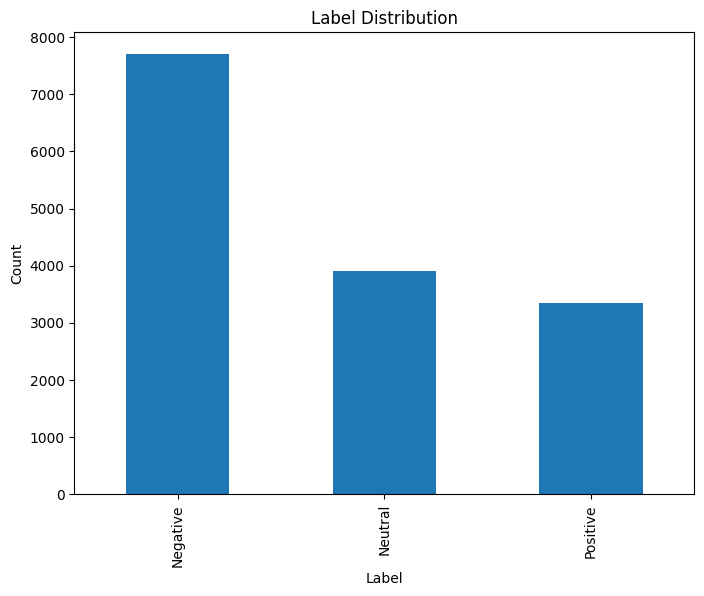

In [63]:
def plot_label_distribution(df):
  plt.figure(figsize=(8, 6))
  df['label'].value_counts().plot(kind='bar')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Label Distribution')
  plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
  plt.show()

plot_label_distribution(df)

## Splitting the dataset

Create a dataframe that only consists of the columns/features needed for the task of sentiment analysis.

In [78]:
data_df = df[['full_text', 'label']].copy()

train_df, temp_df = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

# print(f"Train: {len(train_df)} samples")
# print(f"Validation: {len(val_df)} samples")
# print(f"Test: {len(test_df)} samples")

# output dataframe of split names and split sizes
splits_df = pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Size': [len(train_df), len(val_df), len(test_df)]
})
splits_df

,Set,Size
0,Training,11956
1,Validation,1495
2,Testing,1495


 ## Exporting processed datasets

In [81]:
if not os.path.exists(EXPORT_DATA_DIR):
    os.makedirs(EXPORT_DATA_DIR)

train_df.to_csv(os.path.join(EXPORT_DATA_DIR, "coindesk_train.csv"), index=False)
val_df.to_csv(os.path.join(EXPORT_DATA_DIR, "coindesk_val.csv"), index=False)
test_df.to_csv(os.path.join(EXPORT_DATA_DIR, "coindesk_test.csv"), index=False)

print("Datasets saved to ./data/processed_coindesk_*.csv")

Datasets saved to ./data/processed_coindesk_*.csv
